# "머신러닝을 통한 접근 가이드" 목차
## 1. Library
## 2. Data Loading
## 3. Feature Engineering
### 3-1. Feature Generation
#### CODE SHARE WITH "파베르"님 
#### (https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent)
### 3-2. Feature Engineering
#### 3-2-1. Encoding
#### 3-2-2. Scailing
## 4. Modeling with Pycaret
## 5. Modeling with CatBoostRegressor

## 1. Library

In [1]:
# pip install pycaret

In [2]:
# for "2. Data Loading"
import pandas as pd

# for "3-1. Feature Generation"
import numpy as np

# for "3-2. Feature Engineering"
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import RobustScaler, StandardScaler

# for "4. Modeling with Pycaret"
from pycaret.regression import *

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

## 2. Data Loading

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## 3. Feature Engineering

### 3-1. Feature Generation
#### CODE SHARE WITH "파베르"님 
#### (https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent)
##### Feature Generation과 관련된 EDA는 위의 링크를 참조해주세요 :) 

In [4]:
# Train Data 불러오기 및 오류 데이터 제거
train = pd.read_csv('train.csv')
train_error = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
train = train[~train['단지코드'].isin(train_error)].reset_index(drop=True)
print(train.shape)

(2869, 15)


In [5]:
# Test Data 불러오기 및 오류 데이터 제거
test = pd.read_csv('test.csv')
test_error = ['C2675', 'C2335', 'C1327']
test = test[~test['단지코드'].isin(test_error)].reset_index(drop=True)
print(test.shape)

(1008, 14)


In [6]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

#### (3) 자격유형

test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train = train.drop_duplicates()
test = test.drop_duplicates()

unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

X_train = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter')], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter')], axis=1)

차량보유인구비율, 전용면적(가중합), 차량미보유세대비율, 소형세대, ~총입주민수~, 임대료가중평균 추가

In [7]:
print(X_train.shape)
print(X_test.shape)

(411, 20)
(147, 19)


In [8]:
new_train = pd.read_csv('new_train.csv')
new_test = pd.read_csv('new_test.csv')

In [9]:
new_train = new_train[['단지코드', '차량보유인구비율', '전용면적', '차량미보유세대비율', '소형세대', '임대료']]
new_test = new_test[['단지코드', '차량보유인구비율', '전용면적', '차량미보유세대비율', '소형세대', '임대료']]

In [10]:
X_train = pd.merge(X_train, new_train, on='단지코드', how='left')
X_test = pd.merge(X_test, new_test, on='단지코드', how='left')

In [11]:
X_train = X_train.set_index('단지코드')
X_test = X_test.set_index('단지코드')

In [12]:
print(X_train.shape)
print(X_test.shape)

(411, 25)
(147, 24)


---

---

### 3-2. Feature Engineering
- 필요성?

In [13]:
X_train.head(3)

# 1. 지역은 글자데이터이다.
## 한글은 Catboost 이외에는 받아들일 수 없기  때문에, Encoding 과정이 필요하다.
## 해결법  : 통계치를 반영한 Encoding과, One-Hot Encoding 모두 적용해준다.

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,차량보유인구비율,전용면적,차량미보유세대비율,소형세대,임대료
단지코드,,,,,,,,,,,,,,,,,,,,,,,,,
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.400787,39.0,0.0,0.653211,119432.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.417173,40.0,0.0,0.320724,171133.0
C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.425875,50.0,0.0,0.317881,187414.0


In [14]:
X_train.describe()

# 2. 단위가 다르다.
## 총 세대수, 공가수는 "세대 수"를, "도보 ~~"는 근처의 "개수"를, "단지내주차면수"는 "면적"을 의미하는 등 의미하는 바가 다르다.
## 이 경우에는, Feature의 "Scale"을 동일하게 해주지 않으면 Machine Learning과정에서 가중치 학습에 있어서 오류가 있을 수 있다.
## 해결법 : Robust Scailing을 적용해준다. (Good for outliers)

# 3. 이상치가 보인다.
## "도보 10분 거리 내 버스정류장 수"를 확인하면, 75%까지는 4이나, max는 20인 것을 확인할 수 있다.
## "도보 10분 거리 내 지하철역~`"은 75%까지는 0이지만, max는 3인 것을 확인할 수 있다.
## 이상치는 Linear Regression Model에서 상대적으로 큰 영향력을 끼친다.
## 해결법 : 데이터를 살펴보고, 처리를 결정한다.

# 4. 의미 없는 Feature도 확인되었다.
## "임대건물구분_아파트"의 경우 모두가 1이다.
## 해결법 : 단순 제거해준다.

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,차량보유인구비율,전용면적,차량미보유세대비율,소형세대,임대료
count,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.0,411.000000,411.000000,411.000000,411.000000,411.000000,411.00000,411.000000,411.000000,411.000000,411.000000,411.00000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,722.347932,13.416058,0.124088,3.708029,581.676399,564.318735,0.080292,1.0,0.026764,0.085158,0.746959,0.136253,0.080292,0.07056,0.783455,0.082725,0.119221,0.133820,0.07056,0.406021,44.104623,0.157250,0.474427,182568.367397
std,407.850156,10.325419,0.384681,2.836592,360.180869,386.819089,0.272076,0.0,0.161590,0.279457,0.435284,0.343475,0.272076,0.25640,0.412392,0.275802,0.324444,0.340874,0.25640,0.017224,12.515990,0.345154,0.342216,114596.142305
min,26.000000,0.000000,0.000000,0.000000,13.000000,13.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.366161,25.000000,0.000000,0.000000,0.000000
25%,447.500000,5.000000,0.000000,2.000000,317.500000,286.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.400537,38.000000,0.000000,0.175289,112509.000000
50%,632.000000,13.000000,0.000000,3.000000,515.000000,505.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.405677,42.000000,0.000000,0.514151,153157.000000
75%,922.000000,20.000000,0.000000,4.000000,776.000000,753.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.417544,48.000000,0.000000,0.741570,211876.000000
max,2568.000000,55.000000,3.000000,20.000000,1798.000000,2550.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.468448,136.000000,1.000000,1.000000,879892.000000


In [15]:
X_train = X_train.drop(columns = ['임대건물구분_아파트'])
X_test = X_test.drop(columns = ['임대건물구분_아파트'])

- 필요성 - 3. 이상치가 보인다

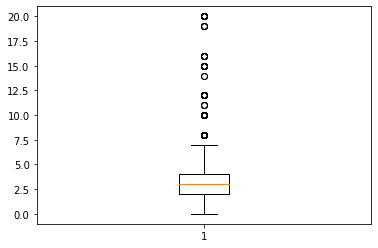

In [16]:
plt.boxplot([train['도보 10분거리 내 버스정류장 수']])
plt.show()

# 20에 가까운 값들이 존재하지만, 따로 처리해주기에는 독립적으로 떨어진 분포가 아니기 때문에, 제거하지 않는다.

In [17]:
display('Train Data')
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
display('Test Data')
display(X_test.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
# 지하철 역 수가 3인 데이터는 제거한다.

display('After Engineering')
X_train = X_train[X_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] != 3]
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))

'Train Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    367
1.0     38
2.0      5
3.0      1
Name: 총세대수, dtype: int64

'=================================================='

'Test Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    136
1.0      8
2.0      3
Name: 총세대수, dtype: int64

'=================================================='

'After Engineering'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    367
1.0     38
2.0      5
Name: 총세대수, dtype: int64

#### 3-2-1. Encoding

In [18]:
%%time
encoding_features = ['지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)']
for f in encoding_features:
    mapping = X_train.groupby([f])['등록차량수'].agg(['mean','median','std'])
    mapping_values = []
    for l in X_train[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_train.index)
    X_train = pd.concat([X_train,bincount], axis= 1).drop(columns = [f])

    mapping_values = []
    for l in X_test[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_test.index)
    X_test = pd.concat([X_test,bincount], axis= 1).drop(columns = [f])

Wall time: 102 ms


In [19]:
X_train.columns

Index(['총세대수', '공가수', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', '임대건물구분_상가',
       '공급유형_공공임대(50년)', '공급유형_공공임대(5년/10년/분납/분양)', '공급유형_국민임대/장기전세',
       '공급유형_영구임대', '공급유형_임대상가', '공급유형_행복주택', '자격유형_A', '자격유형_D',
       '자격유형_국민임대/장기전세_공급대상', '자격유형_영구임대_공급대상', '자격유형_행복주택_공급대상', '차량보유인구비율',
       '전용면적', '차량미보유세대비율', '소형세대', '임대료', '지역_mean', '지역_median', '지역_std',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_std'],
      dtype='object')

#### 3-2-2. Scailing

In [20]:
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '차량보유인구비율', '전용면적', '차량미보유세대비율', '소형세대', '임대료',
                     '지역_mean', 
                     '지역_median',
                     '지역_std', 
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_std'
                    ]

In [21]:
# fig, axes = plt.subplots(2,5, figsize= (12,12))

# i = 0
# for f in scailing_features:
#     c = i % 5
#     r = i // 5
    
#     axes[r,c].hist(x = f, bins =50, data = X_train)
#     i += 1
# plt.show()


# # 지역은 이상치가 확인 => Robust Scailing
# # 도보 -> std 제거
# # 나머지는 Standard

In [22]:
# 도보 10분거리 std는 그림상 의미가 없기에 Drop
X_train = X_train.iloc[:,:-1]
X_test = X_test.iloc[:,:-1]

In [23]:
# 지역은  Scailing

scaler = RobustScaler()
loc_f = [    '지역_mean', 
             '지역_median',
             '지역_std', ]
X_train.loc[:, loc_f] = scaler.fit_transform(X_train[loc_f])
X_test.loc[:, loc_f] = scaler.transform(X_test[loc_f])

In [24]:
# 나머지 Scailing
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '차량보유인구비율', '전용면적', '차량미보유세대비율', '소형세대', '임대료',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                    ]

scaler = StandardScaler()
X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

## 4. Modeling with pycaret

In [25]:
reg = setup(X_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = False, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(X_train.drop(columns = ['등록차량수']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,등록차량수
2,Original Data,"(410, 27)"
3,Missing Values,False
4,Numeric Features,26
5,Categorical Features,0
6,Transformed Train Set,"(409, 26)"
7,Transformed Test Set,"(1, 26)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


- Top5의 모델 선택

In [26]:
top5 = compare_models(n_select = 5, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,116.5949,30315.1623,170.8153,0.7762,0.3458,0.3074,0.0690
catboost,CatBoost Regressor,117.4875,32162.2001,174.7708,0.7690,0.3842,0.3377,0.9460
huber,Huber Regressor,118.7105,30291.4456,170.0892,0.7762,0.4387,0.3449,0.0130
llar,Lasso Least Angle Regression,119.9972,31642.9317,173.4095,0.7666,0.3673,0.3315,0.0070
par,Passive Aggressive Regressor,120.5475,30286.1498,170.8055,0.7725,0.4911,0.3686,0.0110
rf,Random Forest Regressor,120.7277,34409.3081,181.4476,0.7444,0.3508,0.3112,0.0830
lasso,Lasso Regression,121.0547,30738.4350,171.7396,0.7721,0.4370,0.3420,0.0080
br,Bayesian Ridge,121.5397,30618.1535,171.6308,0.7723,0.4645,0.3489,0.0080
ridge,Ridge Regression,122.8596,30823.0846,172.3297,0.7704,0.4738,0.3629,0.0070
lr,Linear Regression,123.5596,31188.3680,173.3138,0.7668,0.4664,0.3689,0.5560


- Top5 Model Tuning

In [27]:
models = []
for m in top5:
    models.append(tune_model(m, 
                             optimize = 'MAE', 
                             choose_better = True,
                            n_iter = 30))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,99.1282,21066.7006,145.1437,0.7904,0.2463,0.2111
1,124.2640,26663.1162,163.2884,0.8309,0.3722,0.3358
2,89.4622,13064.1178,114.2984,0.9136,0.3494,0.3456
3,133.5014,33187.6741,182.1748,0.8038,0.4143,0.4009
4,128.8509,34325.8432,185.2723,0.4613,0.5750,0.6497
5,91.8130,18774.7651,137.0210,0.7946,0.2741,0.2205
6,110.2287,27045.1380,164.4541,0.7975,0.4629,0.4462
7,117.8717,32828.1228,181.1853,0.7775,0.3781,0.3256
8,132.4303,39657.6643,199.1423,0.7467,0.3450,0.2808
9,164.7038,72218.9161,268.7358,0.7645,0.3972,0.3428


In [28]:
voting = blend_models(models, optimize = 'MAE')
voting = tune_model(voting, 
                 optimize = 'MAE', 
                 choose_better = True,
                 n_iter = 30)

voting = finalize_model(voting)
sample = pd.read_csv('data/sample_submission.csv')
layer1_pred = voting.predict(X_test)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,88.2121,19126.4855,138.2985,0.8097,0.2337,0.1850
1,101.2655,21229.9607,145.7050,0.8654,0.2844,0.2265
2,82.2300,11811.5255,108.6808,0.9219,0.3252,0.2091
3,127.1355,31887.7894,178.5715,0.8115,0.3914,0.3612
4,122.7278,32596.9699,180.5463,0.4885,0.5475,0.5860
5,92.6541,19830.7714,140.8218,0.7830,0.2648,0.2045
6,108.5096,23159.2826,152.1817,0.8266,0.4504,0.4230
7,106.2578,27622.2992,166.1996,0.8128,0.3376,0.2800
8,118.5823,34823.2057,186.6098,0.7776,0.2785,0.2232
9,158.7176,69646.6067,263.9064,0.7729,0.3409,0.3032


ValueError: Length of values (147) does not match length of index (150)

In [34]:
submission = pd.DataFrame(columns=['code', 'num'])
submission['code']= X_test.index
submission['num']= layer1_pred
error = pd.DataFrame(np.array([['C2675', 0], ['C2335', 0], ['C1327', 0]]), columns=['code', 'num'])
submission = pd.concat([submission, error]).reset_index(drop=True)
submission.to_csv('pycaret.csv', index=False)

# Modeling with Gradient Boosting Regressor

- Setting Data For Model

In [36]:
X = X_train.drop(columns = ['등록차량수'])
y = X_train['등록차량수']

- Hyper params Tuning

In [37]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [38]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-25 00:09:56,835] A new study created in memory with name: cat_opt
[I 2021-07-25 00:09:57,227] Trial 0 finished with value: 116.06545663681965 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 116.06545663681965.
[I 2021-07-25 00:09:57,453] Trial 1 finished with value: 131.81515330285123 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 0 with value: 116.06545663681965.
[I 2021-07-25 00:09:57,609] Trial 2 finished with value: 123.37744685502781 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 0 with value: 116.06545663681965.
[I 2021-07-25 00:09:57,820] Trial 3 finished with value: 88.2365259386545 and parameters: {'max_depth': 

Best Score: 88.2365259386545
Best trial: {'max_depth': 3, 'colsample_bylevel': 0.8608484485919076, 'subsample': 0.6673295021425665, 'min_child_samples': 46, 'max_bin': 287}


In [39]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

- StratifiedK-Fold for Regression

In [40]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(5)

preds = []
for tr_id, val_id in skf.split(X, y_cat) : 
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    
    pred = cat.predict(X_test)
    preds.append(pred)
cat_pred = np.mean(preds, axis = 0)

In [41]:
cat_pred

array([ 760.71953768, 1189.46996532,  479.99508687,  513.50471532,
       1127.93304907, 1870.43925303,  830.5268824 ,  483.04186562,
        302.88028311,  294.72783962,  455.45636088,  330.98035204,
        357.8663117 ,  220.98429998,  505.11553619,  272.6753554 ,
        432.52327914,  293.60272317,  131.5528479 ,  662.00339078,
        226.48237699,  423.01896913,  483.01528866,  434.01580078,
        407.56894988,  142.31793784,  123.9124142 ,  575.43262003,
        514.43219902,  522.61853731,  929.57769686,  177.38554885,
        464.70979056,  181.11674751,  201.6088976 ,  303.18690382,
        381.62230515,  628.42853145,  824.27470638,  303.6078003 ,
        395.46818785,  531.71282245,  436.41391285,  571.14916183,
        835.301434  , 1311.57792155,  497.02136132,  630.48586837,
        413.03196757,  323.74291856,  794.31158099,  267.62984584,
       1134.76463824,  577.68333334,  572.57086534,  279.59104899,
        608.27934523,  224.02567318,  498.57556508,  225.04915

In [42]:
submission = pd.DataFrame(columns=['code', 'num'])
submission['code']= X_test.index
submission['num']= cat_pred
error = pd.DataFrame(np.array([['C2675', 0], ['C2335', 0], ['C1327', 0]]), columns=['code', 'num'])
submission = pd.concat([submission, error]).reset_index(drop=True)
submission.to_csv('submission_cat.csv', index=False)

In [47]:
submission['num'] = submission['num'].astype('float64')

In [48]:
pd.set_option('display.max_rows', 500)
submission.loc[submission['num']<0, 'num'] = 0
submission.to_csv('submission_cat.csv', index=False)

In [46]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   code    150 non-null    object
 1   num     150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB
